In [84]:
# Изначально добавляем те библиотеки, которые нам понадобятся, а также настройки для красивых графиков

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

sns.set(
        font_scale=4,
        style="whitegrid",
        rc={'figure.figsize':(60,20)}
        )

## 1. Подготовка и проверка данных

Первым делом создаем датафрейм с данными по всем пользователям, которые посещали наше приложение во время эксперимента.
Следом немного изучим данные: посмотрим на содержимое и названия колонок,
взглянем на тип данных в столбцах, а затем проверим, есть ли пропущенные значения

In [107]:
active_users = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/active_users.csv')
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [5]:
active_users.dtypes

user_id      int64
country     object
platform    object
sex         object
dtype: object

In [6]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

Отлично. Колонки названы удобно, тип данных соответствует самим данным, пропущенные значения отсутствуют.
Проделаем то же самое с двумя оставшимися файлами - разбивкой пользователей на группы и информацией о транзакциях.
Контроьная группа имеет маркер "A", тестовая - "B"

In [8]:
groups = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/groups.csv')
groups

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B
...,...,...
74571,1010,B
74572,7785,A
74573,1783,B
74574,1164,A


In [9]:
groups.dtypes

user_id     int64
group      object
dtype: object

In [10]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [11]:
purchases = pd.read_csv('https://stepik.org/media/attachments/lesson/426730/purchases.csv')
purchases

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0
...,...,...
536,5648,1908.0
537,2277,1912.0
538,5032,1911.0
539,908,1910.0


In [12]:
purchases.dtypes

user_id      int64
revenue    float64
dtype: object

In [13]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

## 2. Отбор нужных данных для анализа результатов эксперимента

Данные подготовлены хорошо, и мы в этом убедились. 

Основной вопрос нашего эксперимента - появлияла ли новая модель оплаты на выручку, а точнее увеличилась выручка или нет.
Отличный статистический показатель для оценки увеличения/уменьшения прибыли - среднее значение.

Нас интересуют только те пользователи, которые вошли в приложение во время эксперимента и совершили оплату
Создадим результирующий датафрейм на основе первой таблицы и таблицы с покупками. Так мы получим только тех пользователей,
которые совершили покупки во время эксперимента.

In [15]:
active_users_pays = purchases.merge(active_users, how='inner', on='user_id')
active_users_pays

,user_id,revenue,country,platform,sex
0,4412,1000.0,Russia,android,female
1,5790,1002.0,Sweden,android,male
2,2627,300.0,Russia,ios,female
3,7324,1910.0,Sweden,android,female
4,7666,701.0,Sweden,android,female
...,...,...,...,...,...
387,5648,1908.0,Sweden,android,female
388,2277,1912.0,Sweden,ios,female
389,5032,1911.0,Sweden,ios,male
390,908,1910.0,Sweden,android,male


Интересно, что у нас осталось 392 пользователя. То есть имеются пользователи, которые совершали оплату без входа в приложение.
Позволим этим пользователям быть "за бортом" эксперимента, т.к. они не пользовались механикой оплаты в приожении.

Очевидно, что в таблице разбивки на группы пользователей гораздо больше, почти 75 тысяч.
Возможно, разбивка на группы была сделана вообще по всем пользователям, но нас интересуют только те, кто зашел в приложение
и совершил покупку. Подготавливаем конечный датафрейм.

In [18]:
active_users_pays_exp = active_users_pays.merge(groups, how='left', on='user_id')
active_users_pays_exp

,user_id,revenue,country,platform,sex,group
0,4412,1000.0,Russia,android,female,A
1,5790,1002.0,Sweden,android,male,B
2,2627,300.0,Russia,ios,female,B
3,7324,1910.0,Sweden,android,female,B
4,7666,701.0,Sweden,android,female,B
...,...,...,...,...,...,...
387,5648,1908.0,Sweden,android,female,B
388,2277,1912.0,Sweden,ios,female,B
389,5032,1911.0,Sweden,ios,male,B
390,908,1910.0,Sweden,android,male,B


Проверим сами себя - посчитаем сумму "A" и "B" в столбце "group".
Если сумма не сойдется с количеством строк - значит в наш датафрейм попали пользователи, которые вошли в приложение, совершили покупку, но по какой-то причине ранее не были определены ни в одну группу. Такие данные нас не интересуют.

In [19]:
active_users_pays_exp.group.value_counts().sum()

392

## 3. Изучение выборок и переменной revenue. Выбор критерия для проверки результатов A/B-теста

Отлично. Теперь у нас есть результирующая таблица со всеми интересующими нас данными.
В условиях не сказано о проверке влияния факторов страны и ОС, на которой пользователь использует приложение,
поэтому мы не будем обращать на эти колонки внимания (но удалять на всякий случай все равно не будем).
Теперь взглянем на то, как произошла разбивка по группам - в идеале выборки должны быть одинакового размера

In [21]:
active_users_pays_exp.groupby('group', as_index=False).agg({'user_id' : 'count'})

,group,user_id
0,A,78
1,B,314


In [22]:
active_users_pays_exp.user_id.nunique()

392

Интересно получается. Все пользователи уникальные, но в  тестовую группу попало 314 пользователей, а в контрольную - всего 78. Давайте теперь изучим самую волнующую переменную - выручку.

In [24]:
active_users_pays_exp.groupby('group').agg({'revenue':'mean'})

,revenue
group,
A,943.564103
B,1267.875796


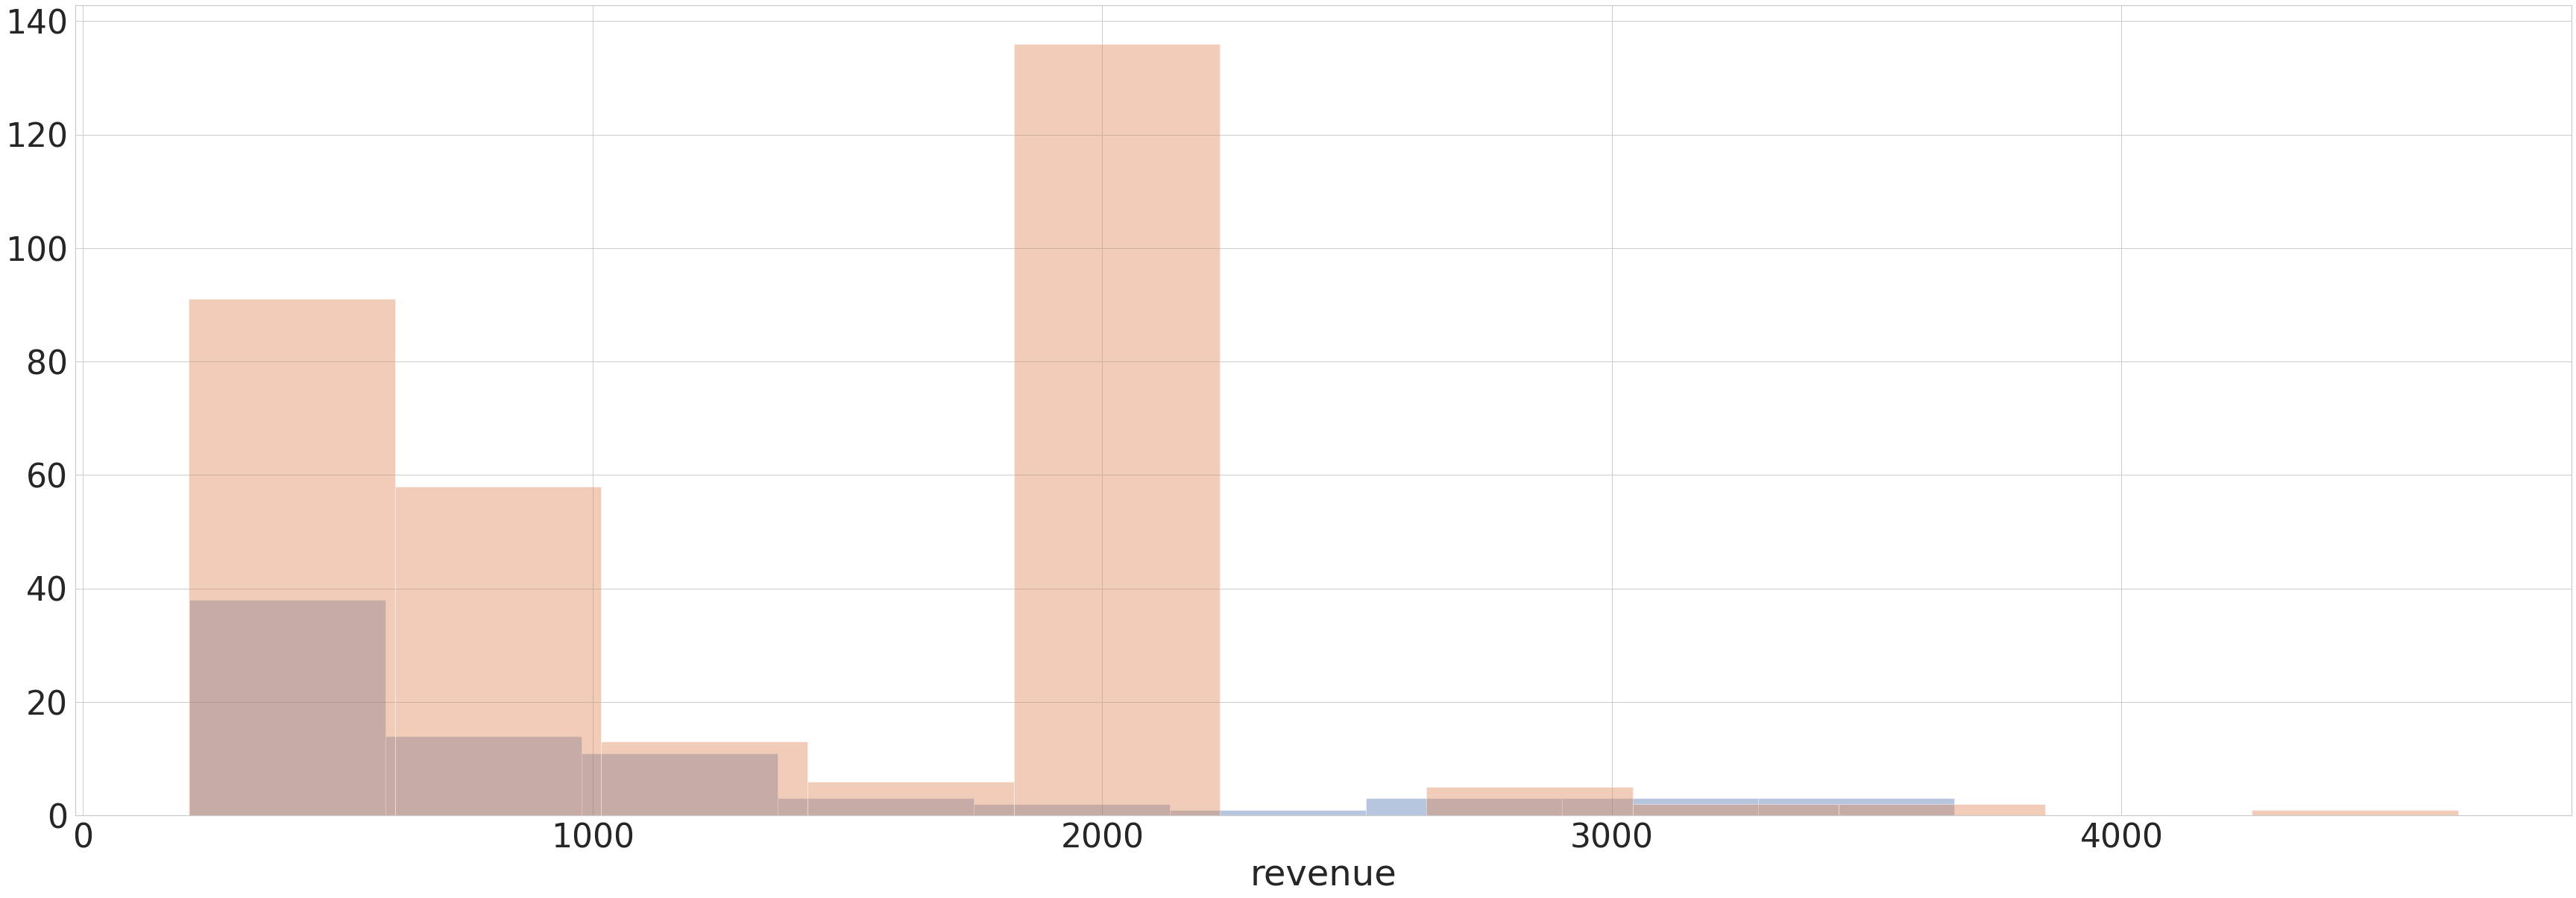

In [85]:
sns.distplot(active_users_pays_exp.query('group == "A"').revenue, kde=False)
sns.distplot(active_users_pays_exp.query('group == "B"').revenue, kde=False)

Среднее значение по тестовой группе выше, на графике также видно "превосходство" тестовой группы над контрольной.
Отличия, очевидно, есть. Но являются ли они статистически значимыми? Продолжаем поиск и смотрим на всё распределение выручки

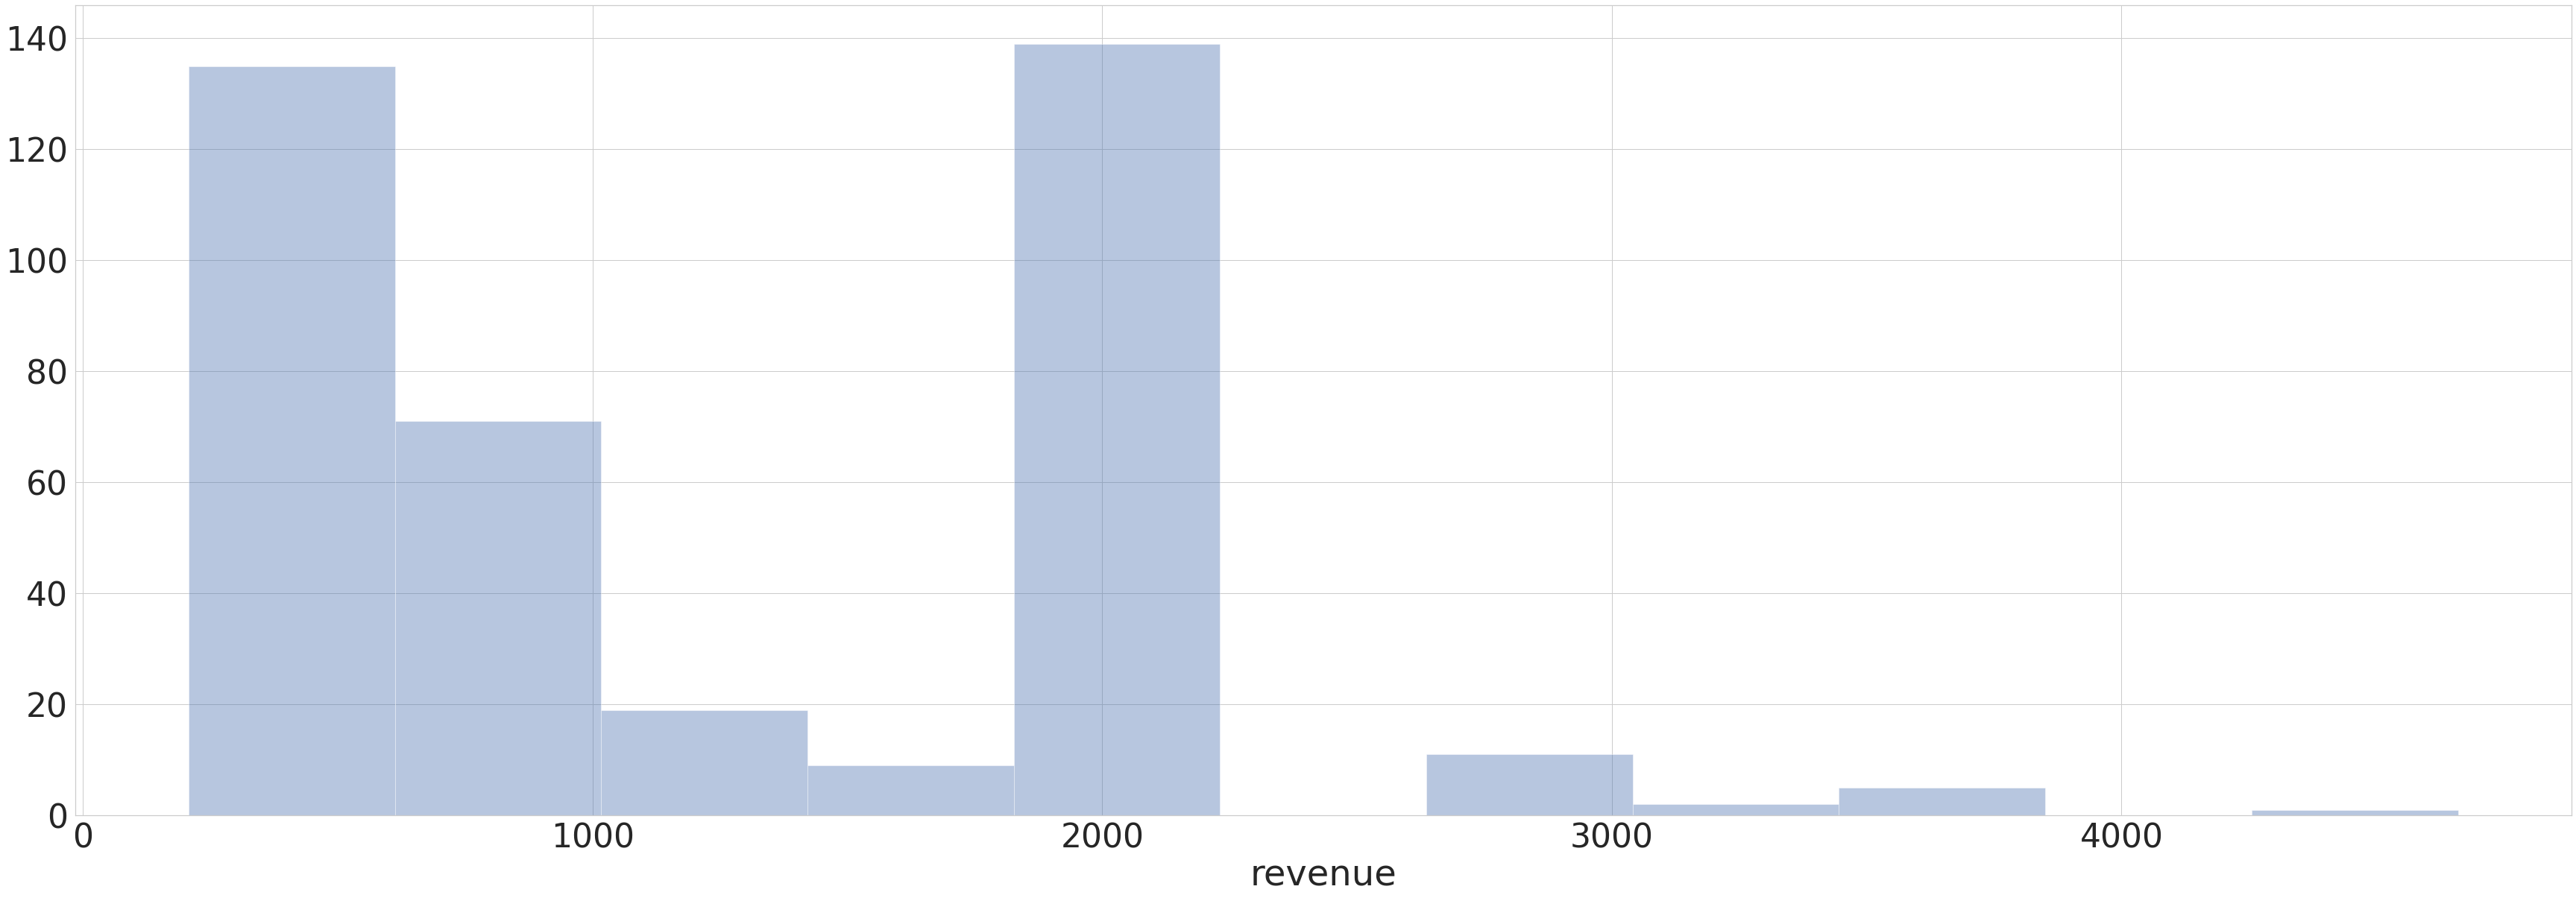

In [86]:
sns.distplot(active_users_pays_exp.revenue, kde=False)

Распределение, мягко говоря, сильно отличается от нормального и имеет огромные выбросы.
Кажется, что можно забыть про параметрические тесты, но шанс еще есть. Попробуем логарифмировать значения выручки и посморим, как изменится наше распределение.

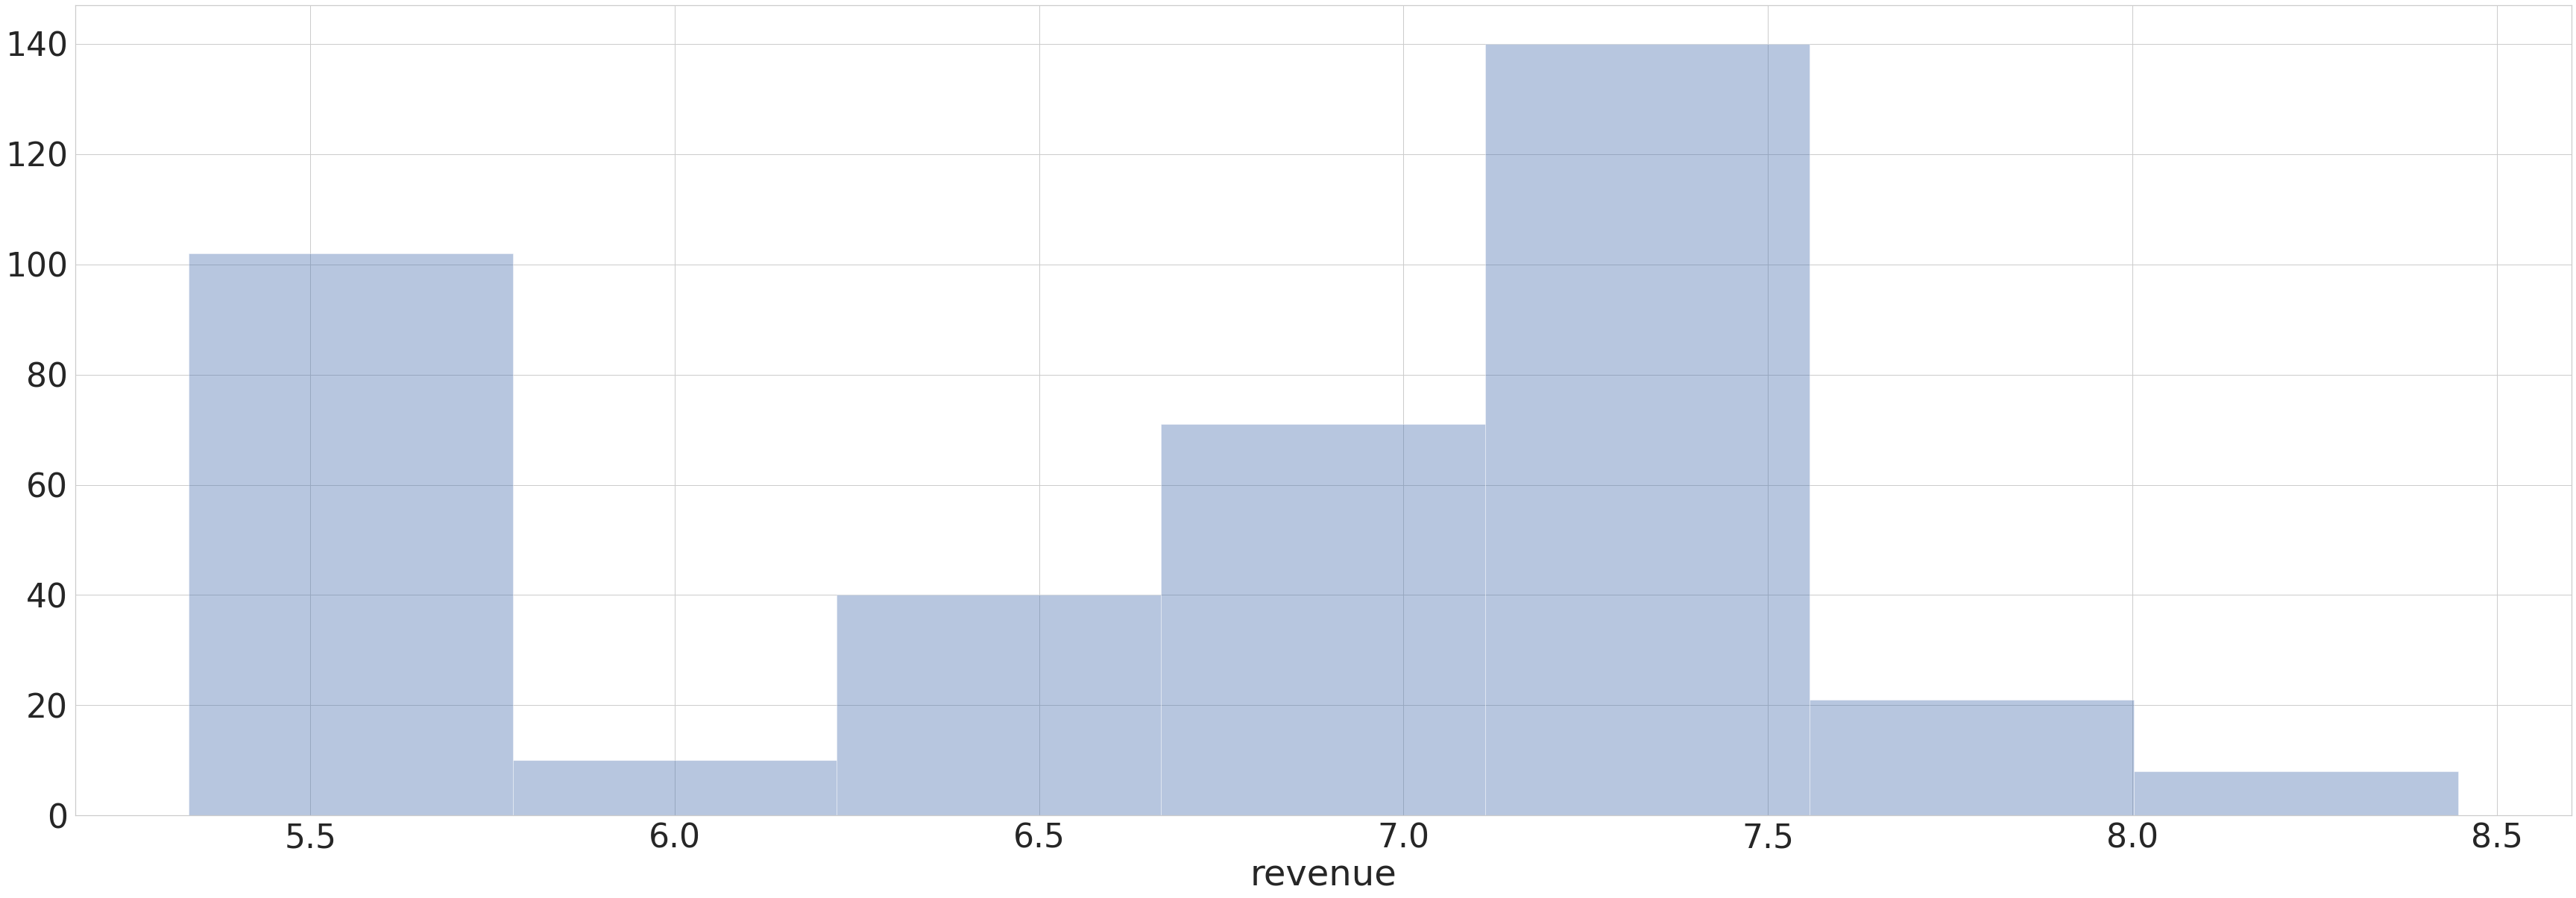

In [87]:
sns.distplot(np.log(active_users_pays_exp.revenue), kde=False)

Однозначной уверенности по прежнему нет. Дадим распределению последний шанс - проверим его на нормальность с помощью теста Шапиро-Уилка

In [31]:
stats.shapiro(np.log(active_users_pays_exp.revenue))

(0.88338303565979, 1.1665325838185404e-16)

Как мы видим, p-value гораздо меньше 0.05, а это значит, что нулевая гипотеза о том, что выборка взята из нормального распределения, отклоняется.
Кажется, мы бы могли использовать U-критерий Манна-Уитни, т.к. имеем количественный тип данных, распределенный ненормальным образом.
К сожалению, это не так, ведь для применения этого критерия в выборках не должно быть одинаковых значений (или их должно быть меньше 10). А такие значения у нас точно есть. Это видно даже по графику, но все же давайте убедимся.

In [33]:
active_users_pays_exp.groupby('revenue').agg({'group' : 'count'}).head()

,group
revenue,
207.0,1
208.0,13
209.0,11
210.0,5
211.0,2


In [34]:
active_users_pays_exp.query('revenue == 208.0')

,user_id,revenue,country,platform,sex,group
5,1056,208.0,Russia,ios,male,B
44,6948,208.0,Sweden,android,female,B
135,6988,208.0,Russia,android,male,B
168,4735,208.0,Russia,ios,male,B
197,5122,208.0,Sweden,ios,male,B
209,1260,208.0,Russia,ios,male,A
214,1482,208.0,Russia,android,male,A
273,8201,208.0,Sweden,android,male,B
303,7136,208.0,Russia,android,female,B
311,5046,208.0,Sweden,ios,female,A


На примере значения 208.0 мы убедились, что оно повторяется как внутри каждой группы, так и между группами.
Что мы имеем в итоге: количественные данные распределены ненормальным образом, трансформаниця переменной не помогла, условие для применения критерия Манна-Уитни не выполняется, да еще и размеры выборок (групп) отличаются друг от друга примерно в 4.5 раза. Принимая во внимание все вышеописанное, нетрудно догадаться, что лучшим выходом из ситуации будет применение bootstrap'a.

Let's do this!

## 4. Применение bootstrap и интерпретация результатов эксперимента

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа.

Нулевая и альтернативная гипотезы в нашем случае будут такими:

H0 = никаких изменений нет, обе группы принадлежат одной ГС, разница средних случайна.

H1 = изменения есть, группы принадлежат разным ГС, разница средних обсуловлена работой новой механики оплаты

In [88]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки (контрольная группа)
    data_column_2, # числовые значения второй выборки (тестовая группа)
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # проверяем гипотезу об увеличении среднего чека
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # уравниваем размер выборок, взяв максимум
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки для контрольной и тестовой групп
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # значения обязательно должны вернуться в выборку
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # берём среднее от распределения разностей и добавляем в переменную
        
    pd_boot_data = pd.DataFrame(boot_data) # собираем датафрейм из средних
    
    # Далее считаем доверительный интервал для среднего. Если доверительный интервал попадёт в 0, то при уровне значимости
    # в 95% мы примем нулевую гипотезу
    # Используем перцентильный метод расчета доверительного интервала. Для этого берем 95% площади распределния, 
    # вычислив 2.5 и 97.5 перцентили в бут-распределнии.
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    # Вычисляем p-value по нормальному распределению
    
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.vlines(ci,ymin=0,ymax=300,linestyle='--')
    plt.xlabel('boot_data', fontsize = 70)
    plt.ylabel('frequency', fontsize = 70)
    plt.title("Histogram of boot_data", fontsize = 100, pad = 50)
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

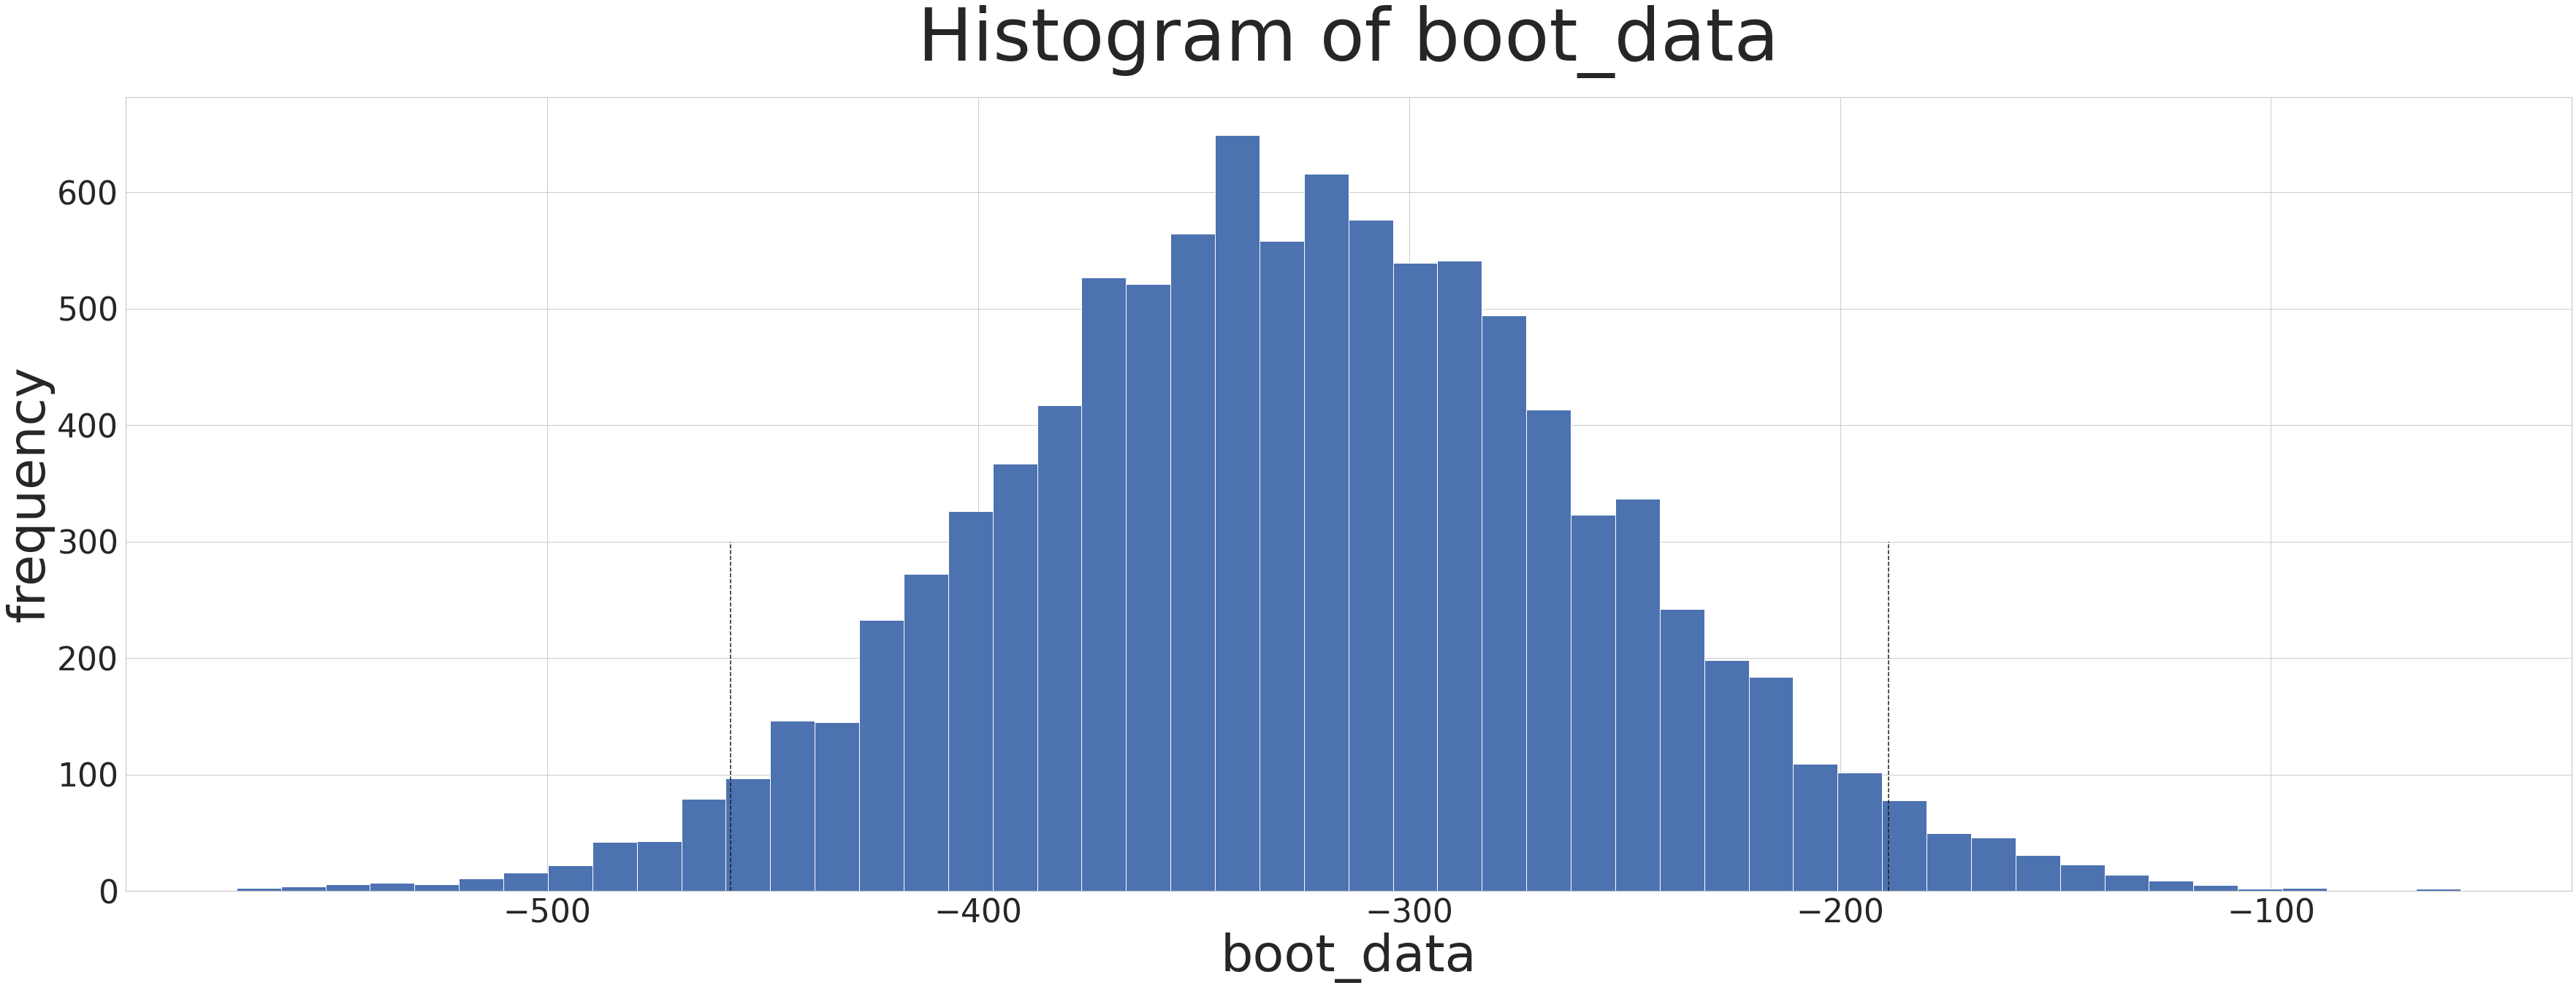

In [90]:
booted_data = get_bootstrap(
    active_users_pays_exp.query('group == "A"').revenue, active_users_pays_exp.query('group == "B"').revenue, boot_it = 10000)

In [91]:
booted_data['ci']

,0
0.025,-457.398248
0.975,-188.738137


In [92]:
booted_data['p_value']

1.9557472318689284e-06

Бутстрап проведен: доверительный интервал не попал в 0, а это означает, что принимается альтернативная гипотеза - **статистические значимые различия подтверждены** и новая механика оплаты действительно повлияла на увеличение среднего чека.

Решение - выкатываем новую механику оплаты на всех пользователей.

# P.S. 
Вообще-то критерий Манна-Уитни также показал наличие статистически значимых различий, но его примененение, как мне кажется, обосновано в меньшей степени, чем примененеие бутстрапа.

Тем не менее, классический и практический методы дали одинаковые результаты, а это не может не радовать!

In [113]:
stats.mannwhitneyu(active_users_pays_exp.query('group == "A"').revenue, active_users_pays_exp.query('group == "B"').revenue)

MannwhitneyuResult(statistic=8961.0, pvalue=0.00011969540057293039)